# Import Libraries & Settings

In [1]:
! pip install shap


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Dealing with dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


#Shap Values
import shap


# Base
from sklearn.datasets import fetch_california_housing

# Create Table
from tabulate import tabulate
from pprint import pprint

# Hyperparameters
from sklearn.model_selection import RandomizedSearchCV


In [20]:
def print_table_results (results_table):

  cols_name = ["Model", "MSE", "R^2 Score"]

# Find the index of the row with the maximum R^2 Score value
  max_r2_index = max(range(len(results_table)), key=lambda i: results_table[i][2])

# Define ANSI escape codes for color formatting
  color_start = '\033[92m'  # Green color
  color_end = '\033[0m'  # Reset color

# Iterate through rows and print, coloring the row with the maximum R^2 Score value
  for i, row in enumerate(results_table):
      if i == max_r2_index:
          # Print the row with green color
          print(color_start + tabulate([row], headers=cols_name, tablefmt="fancy_grid") + color_end)
      else:
          # Print other rows without color
          print(tabulate([row], headers=cols_name, tablefmt="fancy_grid"))

# Base & Data Preparation

In [3]:
california_housing = fetch_california_housing(as_frame=True)
california_housing

{'data':        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
 1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
 2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
 3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
 4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
 ...       ...       ...       ...        ...         ...       ...       ...   
 20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
 20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
 20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
 20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
 20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   
 
        Longitude 

In [4]:
df_housing = pd.DataFrame(california_housing['data'], columns=california_housing['feature_names'])
df_housing['MedHouseVal_target'] = california_housing['target']
df_housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal_target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
print(fetch_california_housing(as_frame=True)['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
X = df_housing[['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
y = df_housing['MedHouseVal_target']

In [7]:
X.shape

(20640, 8)

In [8]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal_target, Length: 20640, dtype: float64

In [9]:
y.shape

(20640,)

In [10]:
# Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeling

### Linear Regression

In [11]:
# Using Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

#Predict using the test 
y_pred = model_lr.predict(X_test)

#Evaluating the model
mse_lr = mean_squared_error(y_test,y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f'Linear Regression Metrics')
print(f'----------')
print(f'Mean Squared Error: {mse_lr}')
print(f'R^2 Score: {r2_lr}')

Linear Regression Metrics
----------
Mean Squared Error: 0.530567782476675
R^2 Score: 0.5957702326061665


### Neural Network

In [12]:
model_nn = MLPRegressor(hidden_layer_sizes=(100,),max_iter=10000)
model_nn.fit(X_train, y_train)

MLPRegressor(max_iter=10000)

In [13]:
#Predict
y_pred_nn = model_nn.predict(X_test)

# Evaluate the model
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'Neural Network Metrics')
print(f'----------')
print(f'Mean Squared Error: {mse_nn}')
print(f'R^2 Score: {r2_nn}')

Neural Network Metrics
----------
Mean Squared Error: 0.7174062585713672
R^2 Score: 0.4534214579040464


### Random Forest

In [14]:
model_rf = RandomForestRegressor(n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [16]:
#Predict
y_pred_rf = model_rf.predict(X_test)

#Evaluate the model
mse_rf = mean_squared_error( y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Metrics')
print(f'----------')
print(f'Mean Squared Error: {mse_rf}')
print(f'R^2 Score: {r2_rf}')

Random Forest Metrics
----------
Mean Squared Error: 0.25685773676080936
R^2 Score: 0.8043048473477692


### Semi Final Results

In [21]:
results_data_semi_final = [["Linear Regression", mse_lr, r2_lr],
                    ["Neural Network", mse_nn, r2_nn],
                    ["Random Forest", mse_rf, r2_rf]]
print_table_results(results_data_semi_final)

╒═══════════════════╤══════════╤═════════════╕
│ Model             │      MSE │   R^2 Score │
╞═══════════════════╪══════════╪═════════════╡
│ Linear Regression │ 0.530568 │     0.59577 │
╘═══════════════════╧══════════╧═════════════╛
╒════════════════╤══════════╤═════════════╕
│ Model          │      MSE │   R^2 Score │
╞════════════════╪══════════╪═════════════╡
│ Neural Network │ 0.717406 │    0.453421 │
╘════════════════╧══════════╧═════════════╛
╒═══════════════╤══════════╤═════════════╕
│ Model         │      MSE │   R^2 Score │
╞═══════════════╪══════════╪═════════════╡
│ Random Forest │ 0.256858 │    0.804305 │
╘═══════════════╧══════════╧═════════════╛


# Shap Values

In [43]:
# Fits the explainer
explainer_rf = shap.Explainer(model_rf.predict, X_train)
# Calculates the SHAP values
shap_values_rf = explainer_rf(X_train) 

ExactExplainer explainer: 14449it [36:42,  6.54it/s]                            


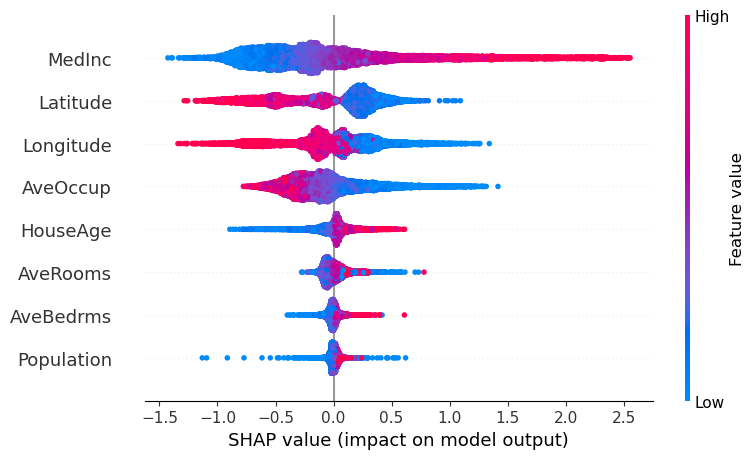

In [45]:
shap.summary_plot(shap_values_rf)

# Insights

By the shap summary above:
- The higher median income in block group, the bigger is the median house value.
- Going to the north regions in California (the higher is the latitude), you can find less median house values.
- Going to the east cost (the high longitude), you can find less median house values.
- The more bedrooms the house has, the higher is the median house value
- The older the house is, the higher is the median value
- The higher is the number of household members, the lower is the median house values.
- Population and average number of room criterias don't make a good division.


# References

In [ ]:
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137